In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
df=pd.read_csv('manual_sample.csv')

In [3]:
df=df[["text","review_stars"]]

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [5]:
train.head(2)

,text,review_stars
70828,"And then there was Edomasa. As in, much, much...",4
71712,"I have been a big Chipotle fan for years, yet ...",2


In [6]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [7]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.review_stars.values)

In [8]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [9]:
print (xtrain.shape)
print (xvalid.shape)

(73053,)
(8118,)


In [10]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [11]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.943 


c:\Users\Rajup\anaconda3\envs\testinggrounds\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [12]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [14]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

c:\Users\Rajup\anaconda3\envs\testinggrounds\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


logloss: 1.148 


In [15]:
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.070 


In [16]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 4.144 


In [18]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.033 


#### Want to test the XGB using the glove embeddings

In [23]:
embeddings_index = {}
f =open("glove.840B.300d.txt",errors = 'ignore', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

2196017it [01:40, 21885.26it/s]

Found 2195892 word vectors.


In [26]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [27]:
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 8118/8118 [00:06<00:00, 1329.09it/s]


In [28]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [29]:
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

[08:58:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


logloss: 1.049 


In [30]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

[09:04:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


logloss: 1.034 


In [31]:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [32]:
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [43]:
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [44]:
history=model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/5
1142/1142 [==============================] - 4s 3ms/step - loss: 1.1631 - val_loss: 1.0057
Epoch 2/5
1142/1142 [==============================] - 3s 3ms/step - loss: 1.0419 - val_loss: 0.9997
Epoch 3/5
1142/1142 [==============================] - 4s 3ms/step - loss: 1.0255 - val_loss: 0.9932
Epoch 4/5
1142/1142 [==============================] - 3s 3ms/step - loss: 1.0134 - val_loss: 0.9942
Epoch 5/5
1142/1142 [==============================] - 4s 3ms/step - loss: 1.0042 - val_loss: 0.9894


In [46]:
import matplotlib.pyplot as plt

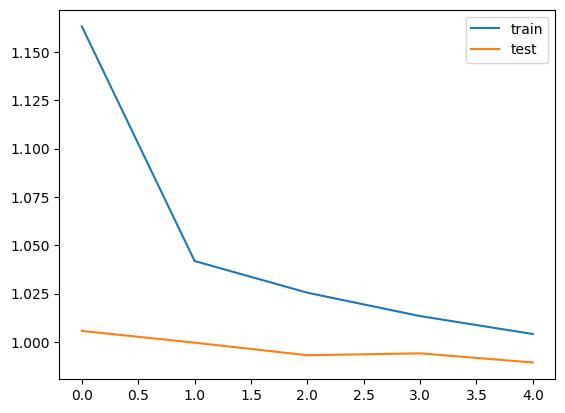

In [52]:
plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="test")
plt.legend()
plt.show()

In [55]:
from keras.utils import pad_sequences

In [56]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [57]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


100%|██████████| 56313/56313 [00:00<00:00, 59987.99it/s]


In [62]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0,activation = "tanh",recurrent_activation="sigmoid",unroll=False,use_bias=True))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [59]:
# from tensorflow import keras
# from keras.layers import LSTM
# LSTM(
#     units,
#     activation='tanh',
#     recurrent_activation='sigmoid',
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     recurrent_initializer='orthogonal',
#     bias_initializer='zeros',
#     unit_forget_bias=True,
#     kernel_regularizer=None,
#     recurrent_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     recurrent_constraint=None,
#     bias_constraint=None,
#     dropout=0.0,
#     recurrent_dropout=0.0,
#     return_sequences=False,
#     return_state=False,
#     go_backwards=False,
#     stateful=False,
#     time_major=False,
#     unroll=False,
#     **kwargs
# )

In [65]:
history1=model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/50
143/143 [==============================] - 28s 191ms/step - loss: 0.9902 - val_loss: 0.9412
Epoch 2/50
143/143 [==============================] - 27s 190ms/step - loss: 0.9782 - val_loss: 0.9286
Epoch 3/50
143/143 [==============================] - 28s 196ms/step - loss: 0.9716 - val_loss: 0.9274
Epoch 4/50
143/143 [==============================] - 28s 197ms/step - loss: 0.9648 - val_loss: 0.9165
Epoch 5/50
143/143 [==============================] - 28s 195ms/step - loss: 0.9593 - val_loss: 0.9305
Epoch 6/50
143/143 [==============================] - 28s 198ms/step - loss: 0.9549 - val_loss: 0.9267
Epoch 7/50
143/143 [==============================] - 28s 198ms/step - loss: 0.9470 - val_loss: 0.9364
Epoch 8/50
143/143 [==============================] - 28s 196ms/step - loss: 0.9446 - val_loss: 0.9228
Epoch 9/50
143/143 [==============================] - 29s 200ms/step - loss: 0.9392 - val_loss: 0.9144
Epoch 10/50
143/143 [==============================] - 29s 201ms/step - l

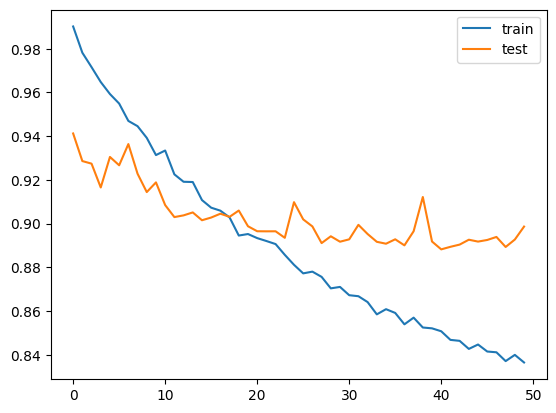

In [67]:
plt.plot(history1.history['loss'],label="train")
plt.plot(history1.history['val_loss'],label="test")
plt.legend()
plt.show()

In [68]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [69]:
history2=model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/50
143/143 [==============================] - 46s 319ms/step - loss: 0.8340 - val_loss: 0.8893
Epoch 2/50
143/143 [==============================] - 44s 307ms/step - loss: 0.8346 - val_loss: 0.8935
Epoch 3/50
143/143 [==============================] - 66s 459ms/step - loss: 0.8331 - val_loss: 0.8884
Epoch 4/50
143/143 [==============================] - 38s 268ms/step - loss: 0.8306 - val_loss: 0.8940
Epoch 5/50
143/143 [==============================] - 66s 461ms/step - loss: 0.8300 - val_loss: 0.8894
Epoch 6/50
143/143 [==============================] - 51s 359ms/step - loss: 0.8340 - val_loss: 0.8905


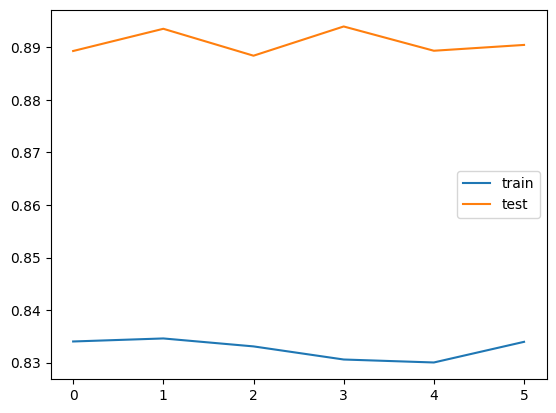

In [71]:
plt.plot(history2.history['loss'],label="train")
plt.plot(history2.history['val_loss'],label="test")
plt.legend()
plt.show()

In [73]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history_bi=model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
143/143 [==============================] - 72s 484ms/step - loss: 1.3457 - val_loss: 1.1411
Epoch 2/100
143/143 [==============================] - 60s 417ms/step - loss: 1.1681 - val_loss: 1.0887
Epoch 3/100
143/143 [==============================] - 58s 406ms/step - loss: 1.1148 - val_loss: 1.0174
Epoch 4/100
143/143 [==============================] - 58s 408ms/step - loss: 1.0686 - val_loss: 0.9991
Epoch 5/100
143/143 [==============================] - 58s 408ms/step - loss: 1.0433 - val_loss: 0.9746
Epoch 6/100
143/143 [==============================] - 63s 440ms/step - loss: 1.0226 - val_loss: 0.9604
Epoch 7/100
143/143 [==============================] - 58s 407ms/step - loss: 1.0020 - val_loss: 0.9613
Epoch 8/100
143/143 [==============================] - 111s 776ms/step - loss: 0.9847 - val_loss: 0.9414
Epoch 9/100
143/143 [==============================] - 131s 919ms/step - loss: 0.9765 - val_loss: 0.9294
Epoch 10/100
143/143 [==============================] - 71s 49

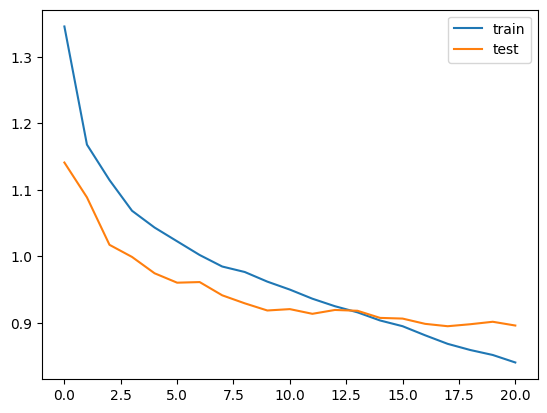

In [74]:
plt.plot(history_bi.history['loss'],label="train")
plt.plot(history_bi.history['val_loss'],label="test")
plt.legend()
plt.show()

In [83]:
predictions=model.predict(xvalid_pad)

254/254 [==============================] - 13s 52ms/step


In [81]:
yvalid

array([3, 4, 1, ..., 0, 0, 4], dtype=int64)

In [93]:
yvalid_enc

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)